In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'plot_overlap_annotation',
        root = '..',
        default_wildcards={'library_prep': 'cDNA', 'platform': 'PacBio', 'counting': 'end'}
    )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_uncor = pd.read_csv(snakemake.input['uncorrected'])
df_cor = pd.read_csv(snakemake.input['corrected'])
#assert df_uncor.shape == df_cor.shape

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
order = ['Known','prefix ISM', 'suffix ISM', 'other ISM', 'NIC', 'NNC', 'Antisense', 'Intergenic'][::-1]
colors = ["#009E73", "#0072B2", "#D55E00", "#E69F00", "#000000", "#CC79A7", 
          "#56B4E9", "#698bac", "#003366", "#F0E442", "lightblue"]
colors_light = [lighten_color(i) for i in colors]

In [6]:
df_cor['novelty'].unique()

array(['Known', 'Intergenic', 'NNC', 'suffix ISM', 'NIC', 'prefix ISM',
       'Antisense', 'other ISM'], dtype=object)

In [8]:
df_uncor.shape

(94486, 3)

In [9]:
df_cor.shape

(99167, 3)

/tmp/ipykernel_26699/3666604659.py:44: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values """. Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  mpatches.Patch(facecolor=colors_light[4],hatch='\\\\"', edgecolor='white', label='baseline'),


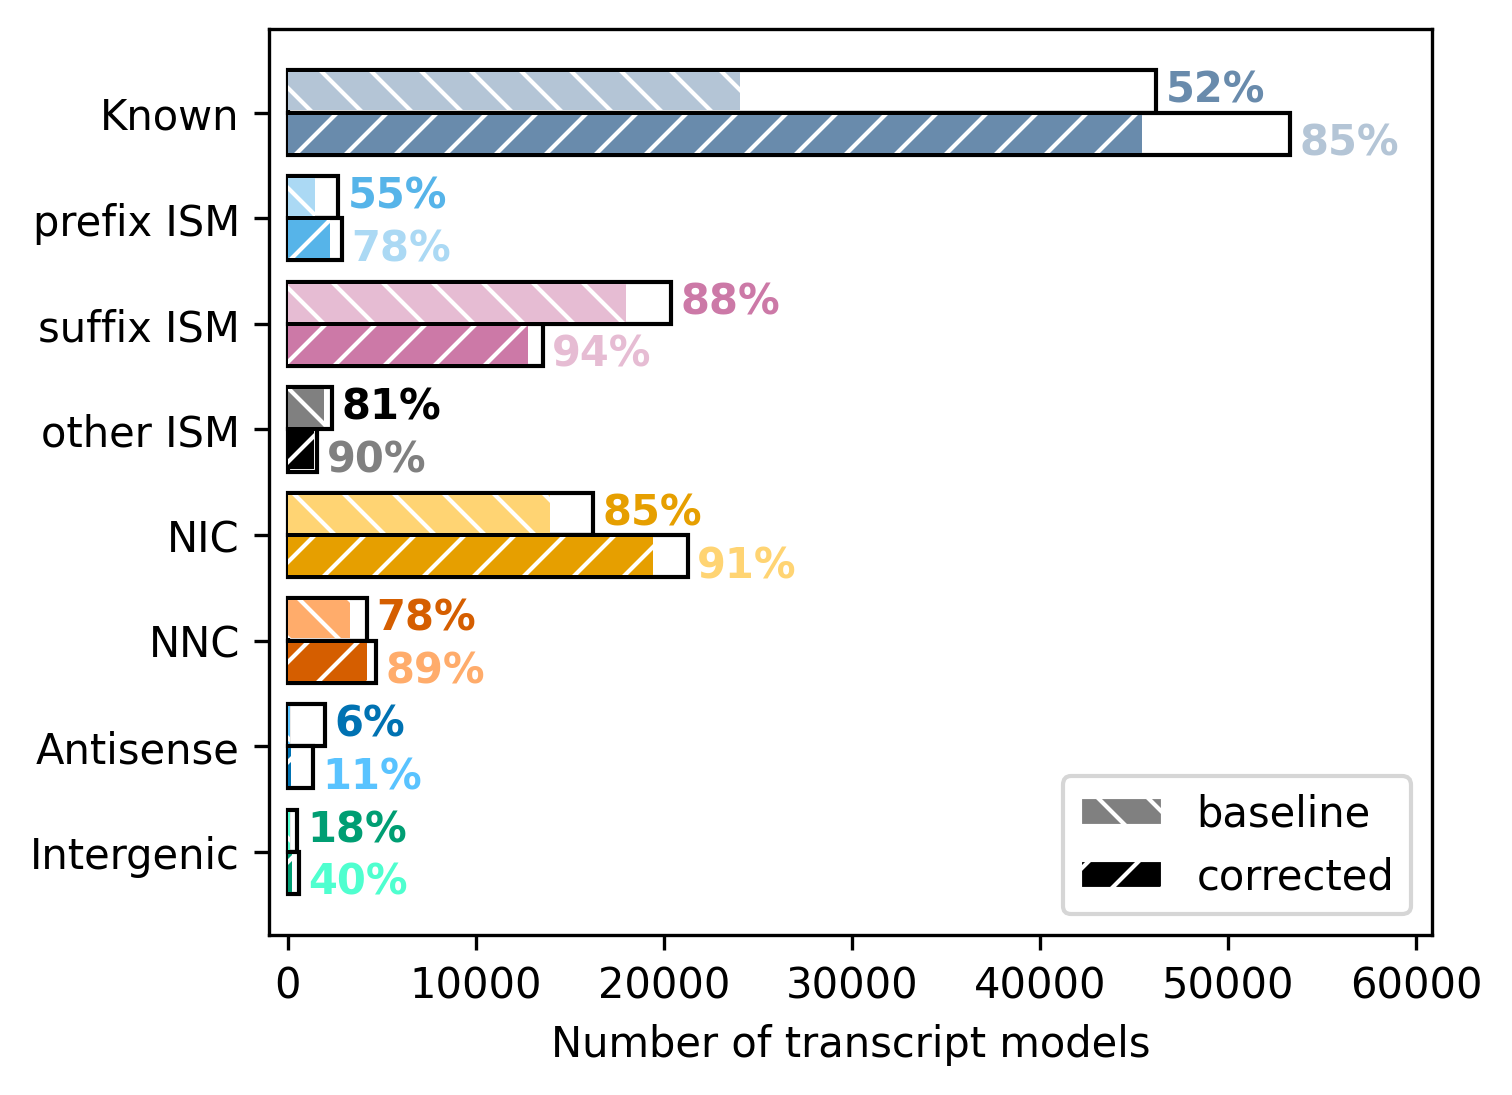

In [30]:
import matplotlib.patches as mpatches

plt.figure(figsize=(5, 4), dpi=300)
#plt.title(f"{snakemake.wildcards['sample']} {snakemake.wildcards['library_prep']} {snakemake.wildcards['platform']}")

df_all_plot = df_uncor.groupby(['novelty']).count().loc[order].reset_index()
df_all_cor_plot = df_cor.groupby(['novelty']).count().loc[order].reset_index()

df_uncor_plot = df_uncor[df_uncor['support'] == 'yes'].groupby(['novelty']).count().loc[order].reset_index()
df_cor_plot = df_cor[df_cor['support'] == 'yes'].groupby(['novelty']).count().loc[order].reset_index()

ax = plt.barh(
    df_all_plot['novelty'].index + 0.2,
    df_all_plot['transcript_id'], 
    edgecolor='black', color='white', height=.4) # height=.8,

ax = plt.barh(
    df_all_cor_plot['novelty'].index - 0.2, 
    df_all_cor_plot['transcript_id'], 
    edgecolor='black', color='white', height=.4) # height=.8,

ax = plt.barh(
    df_uncor_plot['novelty'].index + 0.2,
    df_uncor_plot['transcript_id'], 
    height=.36, hatch="\\\\", linewidth=0, edgecolor='white', label='baseline', color=colors_light)
    
ax = plt.barh(
    df_cor_plot['novelty'].index - 0.2,
    df_cor_plot['transcript_id'],
    height=.36, hatch="//", linewidth=0, edgecolor='white', label='corrected', color=colors)
    
per_uncor = df_uncor_plot['transcript_id'] / df_all_plot['transcript_id']
per_cor = df_cor_plot['transcript_id'] / df_all_cor_plot['transcript_id']

for pu, x, y, c in zip(per_uncor, df_all_plot['transcript_id'], 
                               df_all_plot['novelty'].index, colors):
    plt.text(x + 500, y + 0.1, f'{int(pu * 100)}%', color=c, fontweight='bold')
    
for pc, x, y, cl in zip(per_cor, df_all_cor_plot['transcript_id'],
                           df_all_cor_plot['novelty'].index, colors_light):
    plt.text(x + 500, y - 0.4, f'{int(pc * 100)}%', color=cl, fontweight='bold')

plt.legend(loc=4, handles=[
    mpatches.Patch(facecolor=colors_light[4],hatch='\\\\"', edgecolor='white', label='baseline'),
    mpatches.Patch(facecolor=colors[4], hatch='//', edgecolor='white', label='corrected')
])

max_xlim = max(
    df_all_plot['transcript_id'].max(),
    df_all_cor_plot['transcript_id'].max()
) + 7500


plt.xlim((-1000, max_xlim))
_ = plt.yticks(list(range(len(order))), order)
_ = plt.xticks(np.arange(0, max_xlim, 10_000))

plt.xlabel('Number of transcript models')
plt.savefig(snakemake.output['fig'], bbox_inches='tight', dpi=300)